## Fitting line profiles with Saba/Sherpa

In [1]:
from saba import SherpaFitter
from astropy.modeling.models import Gaussian1D
from astropy.io import fits
from astropy.wcs import WCS

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='notebook', 
        style='whitegrid', 
        palette='dark',
        font_scale=1.5,
        color_codes=True)

In [2]:
%pwd

'/Users/will/Dropbox/OrionWest'

In [3]:
datadir = 'Calibrated/BGsub'

## Looking at a weak [N II] knot

In [4]:
hdu, = fits.open(datadir + '/XX1620-2010-01-236-nii-vhel.fits')

In [5]:
NS, NV = hdu.data.shape
w = WCS(hdu.header)
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'VOPT'  'LINEAR'  
CRVAL : -262994.70077500003  724.797518703  
CRPIX : -55.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1998.61644003  1.24473330937  
NAXIS : 175  512

Get velocity array in km/s.

In [6]:
vels, _ = w.all_pix2world(np.arange(NV), [0]*NV, 0)
vels /= 1000.0 
vels.min(), vels.max()
dv = np.pad(np.diff(vels), (0, 1), 'edge')

In [7]:
knotspec = hdu.data[8:44, :].sum(axis=0)

Fit to the core, making sure all components have velocities that are outside the possible knot region.

In [8]:
bounds = {'amplitude': [0, None], 'stddev': [0.0, 30.0], 'mean': [-10.0, None]}
coremodel = (Gaussian1D(1.0, 5.0, 5.0, bounds=bounds) 
             + Gaussian1D(5.0, 10.0, 5.0, bounds=bounds)
             + Gaussian1D(5.0, 20.0, 5.0, bounds=bounds)
             + Gaussian1D(1.0, 40.0, 5.0, bounds=bounds))


[(-100, 150)]

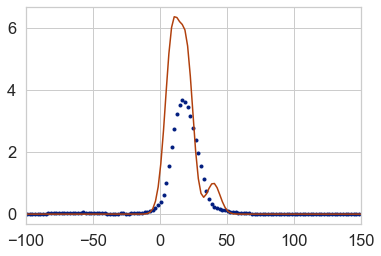

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, coremodel(vels))
ax.set(xlim=[-100, 150])

In [10]:
bgmask = np.abs(vels) > 100.0
spec_errors = np.std(knotspec[bgmask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)

Estimated data errors: 0.0057223104


In [11]:
sfit = SherpaFitter(statistic='chi2', optimizer='levmar', estmethod='confidence')

sfit2 = SherpaFitter(statistic='chi2', optimizer='neldermead', estmethod='confidence')

In [15]:
knotmask = (vels > -100.0) & (vels < -20.0)

In [17]:
vels[~knotmask]

array([-151.07218013, -149.07356369, -147.07494725, -145.07633081,
       -143.07771437, -141.07909793, -139.08048149, -137.08186505,
       -135.08324861, -133.08463217, -131.08601573, -129.08739929,
       -127.08878285, -125.09016641, -123.09154997, -121.09293353,
       -119.09431709, -117.09570065, -115.09708421, -113.09846777,
       -111.09985133, -109.10123489, -107.10261845, -105.10400201,
       -103.10538557, -101.10676913,  -19.16349509,  -17.16487865,
        -15.16626221,  -13.16764577,  -11.16902933,   -9.17041289,
         -7.17179645,   -5.17318001,   -3.17456357,   -1.17594713,
          0.82266931,    2.82128575,    4.81990219,    6.81851863,
          8.81713507,   10.81575151,   12.81436795,   14.81298439,
         16.81160083,   18.81021727,   20.80883371,   22.80745015,
         24.80606659,   26.80468303,   28.80329947,   30.80191591,
         32.80053235,   34.79914879,   36.79776523,   38.79638167,
         40.79499811,   42.79361455,   44.79223099,   46.79084

In [19]:
#coremodel = sfit(coremodel, vels[~knotmask], knotspec[~knotmask], 
#                  err=spec_errors[~knotmask])
coremodel = sfit(coremodel, vels, knotspec, 
                  err=spec_errors)

ValueError: zero-dimensional arrays cannot be concatenated

In [13]:
print(sfit2.fit_info)

{}


<CompoundModel110(amplitude_0=0.11340182614834543, mean_0=-4.538809592730675, stddev_0=6.310050317647467, amplitude_1=3.1536397002982133, mean_1=14.824578573842722, stddev_1=6.54148877733851, amplitude_2=1.7478572364032696, mean_2=25.65594651712883, stddev_2=6.140668459282936, amplitude_3=0.1553691848550982, mean_3=38.53866273299783, stddev_3=13.925247377613347, name='')>

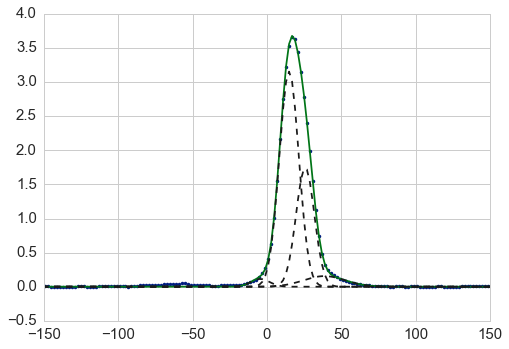

In [335]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, coremodel(vels))
for k in coremodel.submodel_names:
    ax.plot(vels, coremodel[k](vels), ls='--', c='k')
ax.set(xlim=[-150, 150])
coremodel

Calculate the running std of the data using `scipy.ndimage.generic_filter`.  First, test that I understand how it works:

In [336]:
from scipy.ndimage import generic_filter

x = np.arange(10.0)
xx = generic_filter(x, np.std, size=(3,))
print(*['{:.2f}'.format(_) for _ in x])
print(*['{:.2f}'.format(_) for _ in xx])

0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00
0.47 0.82 0.82 0.82 0.82 0.82 0.82 0.82 0.82 0.47


Then apply it to the residual data.  A good compromise is 11 points. 

In [337]:
residspec = knotspec - coremodel(vels)
N = 11
running_mean = generic_filter(residspec, np.mean, size=(N,))
running_std = generic_filter(residspec, np.std, size=(N,))
y1 = running_mean - running_std
y2 = running_mean + running_std

[(-0.05, 0.1), (-150, 150)]

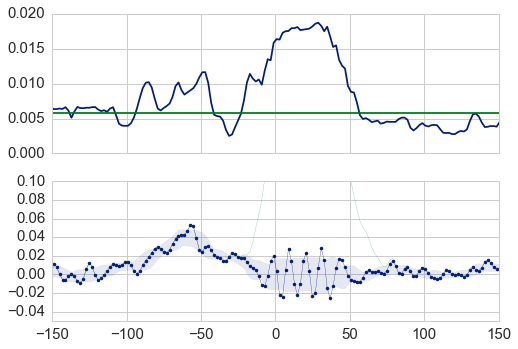

In [338]:
fig, (axx, ax) = plt.subplots(2, 1, sharex=True)

axx.plot(vels, running_std)
axx.plot(vels, spec_errors)
axx.set(ylim=[0.0, None])

ax.plot(vels, residspec, '.-', lw=0.3)
ax.plot(vels, knotspec, '-', lw=0.3, alpha=0.5)
ax.fill_between(vels, y1, y2, alpha=0.1)
ax.set(xlim=[-150, 150], ylim=[-0.05, 0.1])

Now redo the fits to the core, but using the running std of the first residuals as new estimate of the data errors. 

In [339]:
coremodel = sfit2(coremodel, vels[~knotmask], knotspec[~knotmask], 
                  err=running_std[~knotmask])	
print(sfit2.fit_info)

datasets       = None
itermethodname = none
methodname     = neldermead
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude_0', 'wrap_.mean_0', 'wrap_.stddev_0', 'wrap_.amplitude_1', 'wrap_.mean_1', 'wrap_.stddev_1', 'wrap_.amplitude_2', 'wrap_.mean_2', 'wrap_.stddev_2', 'wrap_.amplitude_3', 'wrap_.mean_3', 'wrap_.stddev_3')
parvals        = (0.04504501057267777, -3.6298744347063878, 3.1628215644956925, 2.9094847683448517, 14.621105881126701, 6.2759799127295564, 1.7915369903480307, 25.195759070827023, 6.1348317277199058, 0.24860095311094021, 23.730756223762672, 19.938490392185141)
statval        = 189.07795238673637
istatval       = 206.64801612814435
dstatval       = 17.5700637414
numpoints      = 135
dof            = 123
qval           = 0.000119942425754
rstat          = 1.5372191250954177
message        = Optimization terminated successfully
nfev           = 4497


<CompoundModel110(amplitude_0=0.04504501057267777, mean_0=-3.629874434706388, stddev_0=3.1628215644956925, amplitude_1=2.9094847683448517, mean_1=14.6211058811267, stddev_1=6.275979912729556, amplitude_2=1.7915369903480307, mean_2=25.195759070827023, stddev_2=6.134831727719906, amplitude_3=0.24860095311094021, mean_3=23.730756223762672, stddev_3=19.93849039218514, name='')>

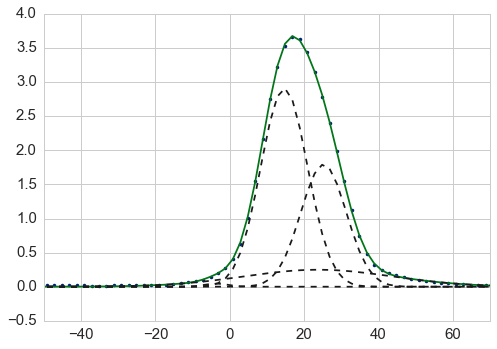

In [340]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, coremodel(vels))
for k in coremodel.submodel_names:
    ax.plot(vels, coremodel[k](vels), ls='--', c='k')
ax.set(xlim=[-50, 70])
coremodel

[(-0.05, 0.1), (-150, 150)]

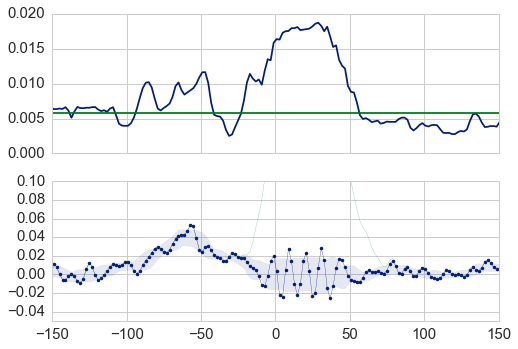

In [341]:
fig, (axx, ax) = plt.subplots(2, 1, sharex=True)

axx.plot(vels, running_std)
axx.plot(vels, spec_errors)
axx.set(ylim=[0.0, None])

ax.plot(vels, residspec, '.-', lw=0.3)
ax.plot(vels, knotspec, '-', lw=0.3, alpha=0.5)
ax.fill_between(vels, y1, y2, alpha=0.1)
ax.set(xlim=[-150, 150], ylim=[-0.05, 0.1])

Finally we can fit the actual knot. Use the new errors from residual running std everywhere except for the knot itself (since they are overestimated there).

In [348]:
new_err = running_std
new_err[knotmask] = spec_errors[knotmask]

In [349]:
knotmodel = Gaussian1D(0.15, -50.0, 10.0)
#knotmodel = sfit(knotmodel, vels[knotmask], residspec[knotmask], 
#                  err=running_std[knotmask])
knotmodel = sfit(knotmodel, vels, residspec, 
                  err=new_err)
print(sfit.fit_info)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude', 'wrap_.mean', 'wrap_.stddev')
parvals        = (0.038342220911064394, -59.130053812164, 22.3201436858193)
statval        = 240.07497441717885
istatval       = 3509.682756386196
dstatval       = 3269.60778197
numpoints      = 175
dof            = 172
qval           = 0.000467986354105
rstat          = 1.395784734983598
message        = successful termination
nfev           = 25


In [350]:
bgspec = hdu.data[44:80, :].sum(axis=0)

<Gaussian1D(amplitude=0.038342220911064394, mean=-59.130053812164, stddev=22.3201436858193, name='')>

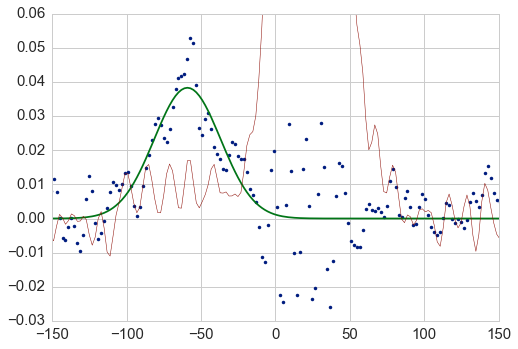

In [351]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.plot(vels, bgspec, lw=0.5)
ax.set(xlim=[-150, 150], ylim=[-0.03, 0.06])
knotmodel

wrap_.amplitude lower bound:	-0.00484781
wrap_.amplitude upper bound:	0.00513847
wrap_.mean lower bound:	-3.19357
wrap_.mean upper bound:	3.34291
wrap_.stddev lower bound:	-3.46794
wrap_.stddev upper bound:	4.11158


[(-0.03, 0.06), (-150, 150)]

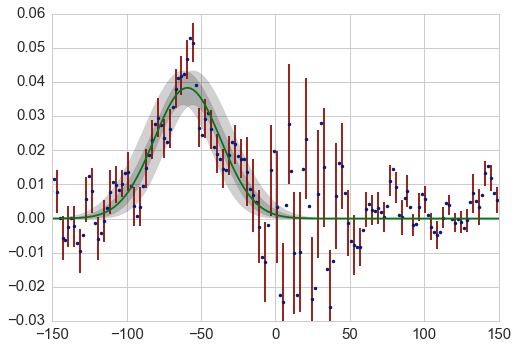

In [352]:
param_errors = sfit.est_errors(sigma=3)

knot_minmin = knotmodel.copy()
knot_maxmax = knotmodel.copy()
knot_minmax = knotmodel.copy()
knot_maxmin = knotmodel.copy()

knot_minmin.amplitude.value += param_errors[2][0]
knot_minmin.mean.value += param_errors[2][1]
knot_minmin.stddev.value += param_errors[2][2]

knot_maxmax.amplitude.value += param_errors[3][0]
knot_maxmax.mean.value += param_errors[3][1]
knot_maxmax.stddev.value += param_errors[3][2]

knot_minmax.amplitude.value += param_errors[2][0]
knot_minmax.mean.value += param_errors[3][1]
knot_minmax.stddev.value += param_errors[2][2]

knot_maxmin.amplitude.value += param_errors[3][0]
knot_maxmin.mean.value += param_errors[2][1]
knot_maxmin.stddev.value += param_errors[3][2]

fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.errorbar(vels, residspec, running_std, fmt=None, errorevery=2)
ax.fill_between(vels, knot_minmax(vels), knot_maxmin(vels), color='k', alpha=0.2)
ax.fill_between(vels, knot_minmin(vels), knot_maxmax(vels), color='k', alpha=0.2)
ax.set(xlim=[-150, 150], ylim=[-0.03, 0.06])

In [353]:
param_errors

(['amplitude', 'mean', 'stddev'],
 (0.038342220911064394, -59.130053812164, 22.3201436858193),
 (-0.0048478124246841489, -3.1935689302613, -3.4679413305705182),
 (0.0051384727044585729, 3.3429066095665405, 4.1115796021225783))

## Look at the same knot in H$\alpha$

In [288]:
hdu, = fits.open(datadir + '/XX1620-2010-01-236-ha-vhel.fits')
NS, NV = hdu.data.shape
w = WCS(hdu.header)
vels, _ = w.all_pix2world(np.arange(NV), [0]*NV, 0)
vels /= 1000.0 
vels.min(), vels.max()

(-151.39536174627995, 196.36548329774004)

In [289]:
knotspec = hdu.data[8:44, :].sum(axis=0)

In [290]:
bounds = {'amplitude': [0, None], 'stddev': [0.0, 30.0], 'mean': [-10.0, None]}
coremodel = (Gaussian1D(1.0, 5.0, 5.0, bounds=bounds) 
             + Gaussian1D(5.0, 10.0, 5.0, bounds=bounds)
             + Gaussian1D(5.0, 20.0, 5.0, bounds=bounds)
             + Gaussian1D(1.0, 40.0, 5.0, bounds=bounds))


[(-100, 150)]

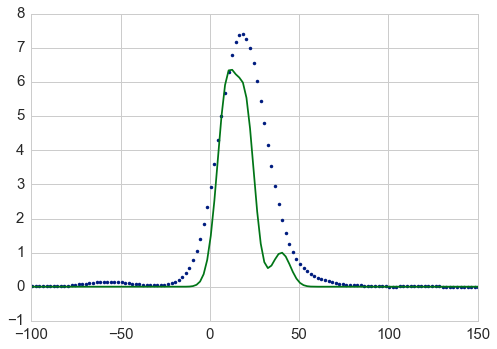

In [291]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, coremodel(vels))
ax.set(xlim=[-100, 150])

In [292]:
bgmask = np.abs(vels) > 100.0
spec_errors = np.std(knotspec[bgmask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)

Estimated data errors: 0.00571439


In [293]:
knotmask = (vels > -100.0) & (vels < -20.0)
coremodel = sfit2(coremodel, vels[~knotmask], knotspec[~knotmask], 
                  err=spec_errors[~knotmask])	
print(sfit2.fit_info)

datasets       = None
itermethodname = none
methodname     = neldermead
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude_0', 'wrap_.mean_0', 'wrap_.stddev_0', 'wrap_.amplitude_1', 'wrap_.mean_1', 'wrap_.stddev_1', 'wrap_.amplitude_2', 'wrap_.mean_2', 'wrap_.stddev_2', 'wrap_.amplitude_3', 'wrap_.mean_3', 'wrap_.stddev_3')
parvals        = (0.34260362701383518, 1.014032049407394, 7.6873611129351316, 0.64914472693061132, 10.987293680919025, 7.5185200585947758, 6.2339078055056252, 19.062059382412016, 12.119242710332484, 0.7980441935822129, 26.064676734170497, 22.548809093607169)
statval        = 142.9944055355072
istatval       = 3540081.811328048
dstatval       = 3539938.81692
numpoints      = 135
dof            = 123
qval           = 0.104996264175
rstat          = 1.1625561425650992
message        = Optimization terminated successfully
nfev           = 7959


<CompoundModel104(amplitude_0=0.3426036270138352, mean_0=1.014032049407394, stddev_0=7.687361112935132, amplitude_1=0.6491447269306113, mean_1=10.987293680919025, stddev_1=7.518520058594776, amplitude_2=6.233907805505625, mean_2=19.062059382412016, stddev_2=12.119242710332484, amplitude_3=0.7980441935822129, mean_3=26.064676734170497, stddev_3=22.54880909360717, name='')>

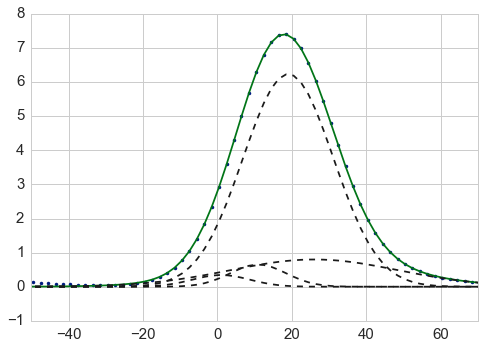

In [294]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, coremodel(vels))
for k in coremodel.submodel_names:
    ax.plot(vels, coremodel[k](vels), ls='--', c='k')
ax.set(xlim=[-50, 70])
coremodel

In [295]:
residspec = knotspec - coremodel(vels)
N = 11
running_mean = generic_filter(residspec, np.mean, size=(N,))
running_std = generic_filter(residspec, np.std, size=(N,))
y1 = running_mean - running_std
y2 = running_mean + running_std

[(-0.03, 0.2), (-150, 150)]

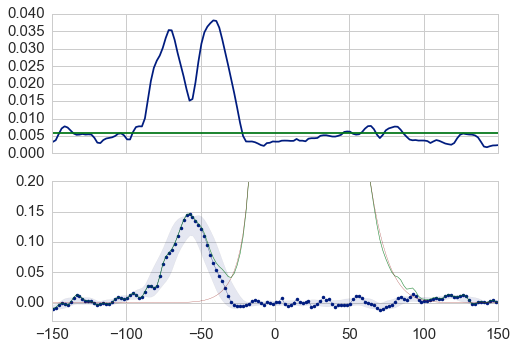

In [296]:
fig, (axx, ax) = plt.subplots(2, 1, sharex=True)

axx.plot(vels, running_std)
axx.plot(vels, spec_errors)
axx.set(ylim=[0.0, None])

ax.plot(vels, residspec, '.-', lw=0.3)
ax.plot(vels, knotspec, '-', lw=0.6, alpha=0.8)
ax.plot(vels, coremodel(vels), '-', lw=0.3, alpha=0.8)
ax.fill_between(vels, y1, y2, alpha=0.1)
ax.set(xlim=[-150, 150], ylim=[-0.03, 0.2])

In this case, the running std doesn't help.  It just gives a similar value to the `spec_errors` estimate in the core of the line.  Then it overestimates the errors in the knot itself because of the gradient.

Note that the core fit has reduced $\chi^2$ of 1.3, which is pretty good. So we can go straight to fitting the knot.

In [300]:
knotmodel = Gaussian1D(0.15, -50.0, 10.0)
#knotmodel = sfit(knotmodel, vels[knotmask], residspec[knotmask], 
#                  err=spec_errors[knotmask])
knotmodel = sfit(knotmodel, vels, residspec, 
                  err=spec_errors)
print(sfit.fit_info)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude', 'wrap_.mean', 'wrap_.stddev')
parvals        = (0.14210580623002592, -57.608064015295334, 12.966683537333839)
statval        = 205.52126239585033
istatval       = 1718.5701516312463
dstatval       = 1513.04888924
numpoints      = 175
dof            = 172
qval           = 0.0411840096281
rstat          = 1.1948910604409904
message        = successful termination
nfev           = 25


<Gaussian1D(amplitude=0.14210580623002592, mean=-57.608064015295334, stddev=12.96668353733384, name='')>

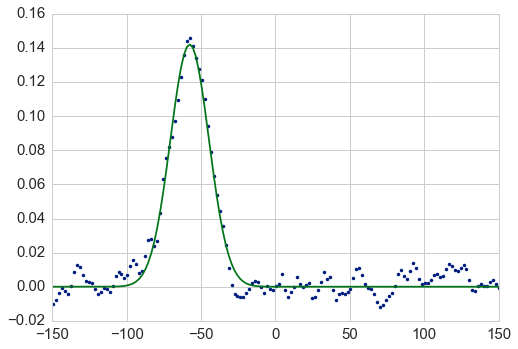

In [301]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.set(xlim=[-150, 150])
knotmodel

wrap_.amplitude lower bound:	-0.00615981
wrap_.amplitude upper bound:	0.00624456
wrap_.mean lower bound:	-0.658935
wrap_.mean upper bound:	0.654324
wrap_.stddev lower bound:	-0.638505
wrap_.stddev upper bound:	0.672602


[(-150, 150)]

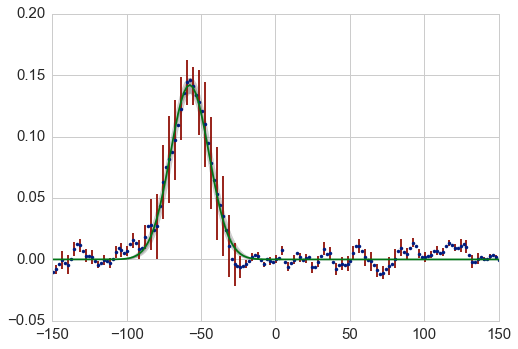

In [305]:
param_errors = sfit.est_errors(sigma=3)

knot_minmin = knotmodel.copy()
knot_maxmax = knotmodel.copy()
knot_minmax = knotmodel.copy()
knot_maxmin = knotmodel.copy()

knot_minmin.amplitude.value += param_errors[2][0]
knot_minmin.mean.value += param_errors[2][1]
knot_minmin.stddev.value += param_errors[2][2]

knot_maxmax.amplitude.value += param_errors[3][0]
knot_maxmax.mean.value += param_errors[3][1]
knot_maxmax.stddev.value += param_errors[3][2]

knot_minmax.amplitude.value += param_errors[2][0]
knot_minmax.mean.value += param_errors[3][1]
knot_minmax.stddev.value += param_errors[2][2]

knot_maxmin.amplitude.value += param_errors[3][0]
knot_maxmin.mean.value += param_errors[2][1]
knot_maxmin.stddev.value += param_errors[3][2]

fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.errorbar(vels, residspec, running_std, fmt=None, errorevery=2)
ax.fill_between(vels, knot_minmax(vels), knot_maxmin(vels), color='k', alpha=0.2)
ax.fill_between(vels, knot_minmin(vels), knot_maxmax(vels), color='k', alpha=0.2)
ax.set(xlim=[-150, 150])

### Trying to improve the fits

In [355]:
from astropy.modeling.models import Const1D

We can give the submodels names:

In [361]:
model = Const1D(1.0, name='first') + Const1D(2.0, name='second')

In [368]:
model['first'], model['second'], model

(<Const1D(amplitude=2.0, name='first')>,
 <Const1D(amplitude=2.0, name='second')>,
 <CompoundModel112(amplitude_0=2.0, amplitude_1=2.0)>)

In [363]:
model.submodel_names

('first', 'second')

We can change a parameter in a submodel, and it is immediately reflected in the composite model. 

In [364]:
model['first'].amplitude *= 2
model

<CompoundModel112(amplitude_0=2.0, amplitude_1=2.0)>

And we can freeze a parameter in a submodel ...

In [366]:
model['second'].fixed['amplitude'] = True

... and it is frozen in the composite model too!

In [367]:
model.fixed

{'amplitude_0': False, 'amplitude_1': True}

In [369]:
model.parameter_constraints

('fixed', 'tied', 'bounds')

In [372]:
model.param_names

('amplitude_0', 'amplitude_1')

## Earlier stuff

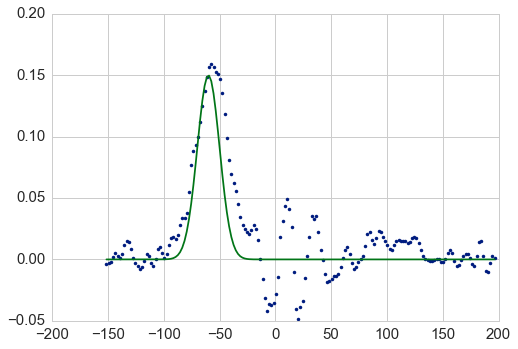

In [15]:
knotmodel = Gaussian1D(0.15, -60.0, 10.0)
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec - coremodel(vels), '.')
ax.plot(vels, knotmodel(vels))

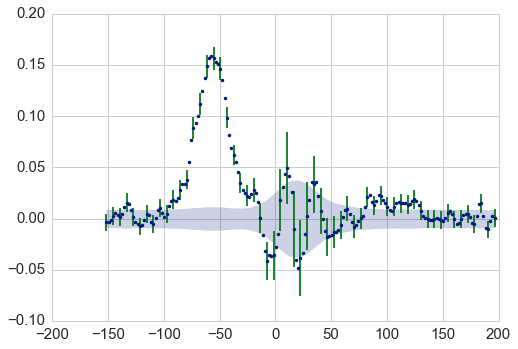

In [16]:
resid_errors = spec_errors + 0.03*np.sqrt((0.02 + knotspec)/knotspec.max())
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=3)
ax.fill_between(vels, -resid_errors, resid_errors, alpha=0.2)


In [17]:
knotmodel = sfit(knotmodel, vels, residspec, err=resid_errors)

In [18]:
print(sfit.fit_info)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude', 'wrap_.mean', 'wrap_.stddev')
parvals        = (0.15496801897002513, -56.676741191046048, 14.889977030013796)
statval        = 165.5971571057872
istatval       = 533.8522915903217
dstatval       = 368.255134485
numpoints      = 175
dof            = 172
qval           = 0.623061133627
rstat          = 0.962774169219693
message        = successful termination
nfev           = 28


<Container object of 3 artists>

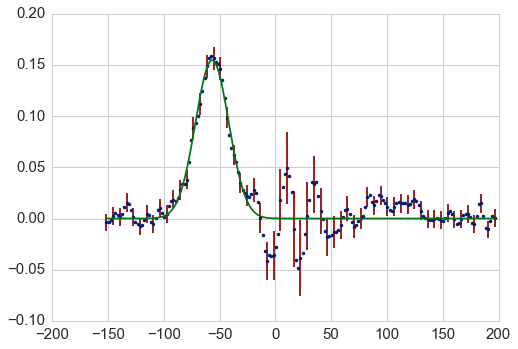

In [19]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=3)


In [20]:
param_errors = sfit.est_errors(sigma=3)
param_errors

wrap_.amplitude lower bound:	-0.0111757
wrap_.amplitude upper bound:	0.0114738
wrap_.mean lower bound:	-1.15877
wrap_.mean upper bound:	1.16158
wrap_.stddev lower bound:	-1.163
wrap_.stddev upper bound:	1.26245


(['amplitude', 'mean', 'stddev'],
 (0.15496801897002513, -56.676741191046048, 14.889977030013796),
 (-0.011175686479814068, -1.1587749724893257, -1.1630040935985981),
 (0.011473805685167648, 1.161579696005461, 1.2624526850642752))

In [21]:
knot_minmin = knotmodel.copy()
knot_maxmax = knotmodel.copy()
knot_minmax = knotmodel.copy()
knot_maxmin = knotmodel.copy()

In [22]:
knot_minmin.amplitude.value += param_errors[2][0]
knot_minmin.mean.value += param_errors[2][1]
knot_minmin.stddev.value += param_errors[2][2]

knot_maxmax.amplitude.value += param_errors[3][0]
knot_maxmax.mean.value += param_errors[3][1]
knot_maxmax.stddev.value += param_errors[3][2]

knot_minmax.amplitude.value += param_errors[2][0]
knot_minmax.mean.value += param_errors[3][1]
knot_minmax.stddev.value += param_errors[2][2]

knot_maxmin.amplitude.value += param_errors[3][0]
knot_maxmin.mean.value += param_errors[2][1]
knot_maxmin.stddev.value += param_errors[3][2]


[(-150, 200)]

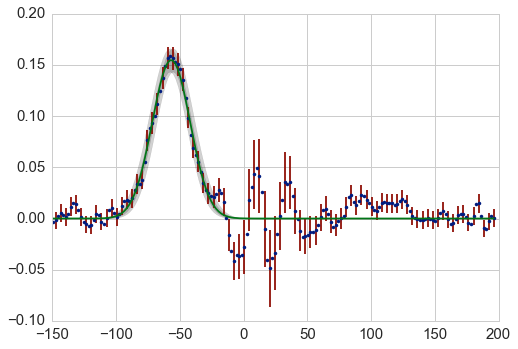

In [23]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=2)
ax.fill_between(vels, knot_minmax(vels), knot_maxmin(vels), color='k', alpha=0.2)
ax.fill_between(vels, knot_minmin(vels), knot_maxmax(vels), color='k', alpha=0.2)
ax.set(xlim=[-150, 200])

Now we try it on a weaker knot: 4257-456

Estimated data errors: 0.00433815


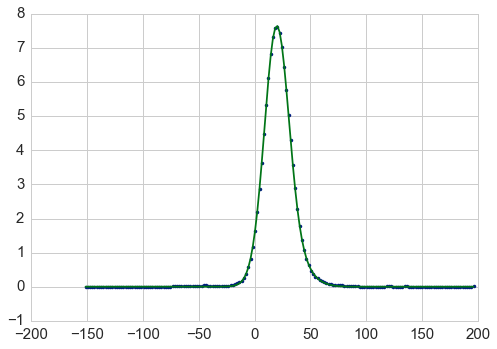

In [24]:
knotspec = hdu.data[312:334, :].sum(axis=0)
coremodel = Gaussian1D(10.0, 20.0, 10.0) + Gaussian1D(4.0, 40.0, 10.0)
bgmask = np.abs(vels) > 100.0
spec_errors = np.std(knotspec[bgmask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)
coremodel = sfit(coremodel, vels, knotspec, err=spec_errors)	
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, coremodel(vels))

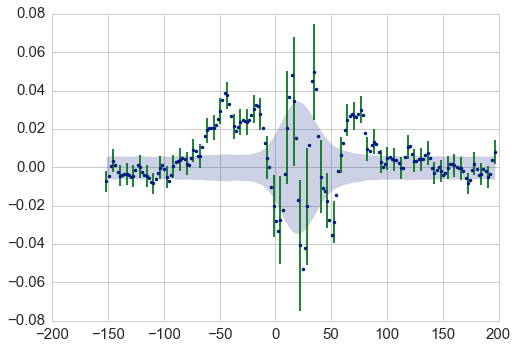

In [25]:
residspec = knotspec - coremodel(vels)
resid_errors = spec_errors + 0.03*np.sqrt((0.02 + knotspec)/knotspec.max())
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=3)
ax.fill_between(vels, -resid_errors, resid_errors, alpha=0.2)

In [26]:
knotmodel = Gaussian1D(0.04, -55.0, 10.0)
knotmodel = sfit(knotmodel, vels, residspec, err=resid_errors)
print(sfit.fit_info)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude', 'wrap_.mean', 'wrap_.stddev')
parvals        = (0.030465470221833952, -37.349349200787998, 21.147611734176806)
statval        = 274.20742168539397
istatval       = 471.09125672547475
dstatval       = 196.88383504
numpoints      = 175
dof            = 172
qval           = 1.15850874873e-06
rstat          = 1.5942291958453139
message        = successful termination
nfev           = 41


<Container object of 3 artists>

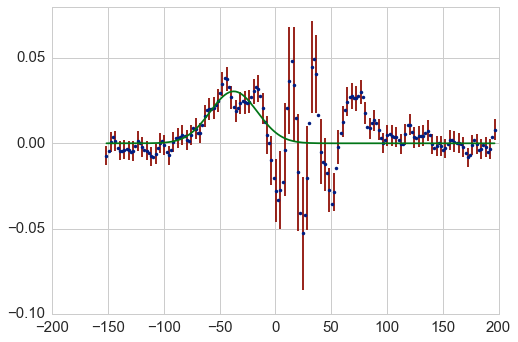

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=2)


wrap_.amplitude lower bound:	-0.00539659
wrap_.amplitude upper bound:	0.00569247
wrap_.mean lower bound:	-5.06473
wrap_.mean upper bound:	6.08849
wrap_.stddev lower bound:	-4.16247
wrap_.stddev upper bound:	5.63651


[(-150, 200)]

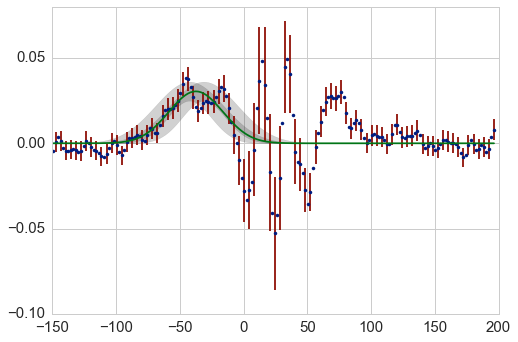

In [28]:
param_errors = sfit.est_errors(sigma=3)

knot_minmin = knotmodel.copy()
knot_maxmax = knotmodel.copy()
knot_minmax = knotmodel.copy()
knot_maxmin = knotmodel.copy()

knot_minmin.amplitude.value += param_errors[2][0]
knot_minmin.mean.value += param_errors[2][1]
knot_minmin.stddev.value += param_errors[2][2]

knot_maxmax.amplitude.value += param_errors[3][0]
knot_maxmax.mean.value += param_errors[3][1]
knot_maxmax.stddev.value += param_errors[3][2]

knot_minmax.amplitude.value += param_errors[2][0]
knot_minmax.mean.value += param_errors[3][1]
knot_minmax.stddev.value += param_errors[2][2]

knot_maxmin.amplitude.value += param_errors[3][0]
knot_maxmin.mean.value += param_errors[2][1]
knot_maxmin.stddev.value += param_errors[3][2]

fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=2)
ax.fill_between(vels, knot_minmax(vels), knot_maxmin(vels), color='k', alpha=0.2)
ax.fill_between(vels, knot_minmin(vels), knot_maxmax(vels), color='k', alpha=0.2)
ax.set(xlim=[-150, 200])


Finally, try it on a region with multiple components.  For instance, the very high velocity component 4255-616 (-100), which overlaps with 4257-614 (-65) and 4257-626 (-10)


Estimated data errors: 0.00474954


[None, (0.0001, 10.0), (-150, 100)]

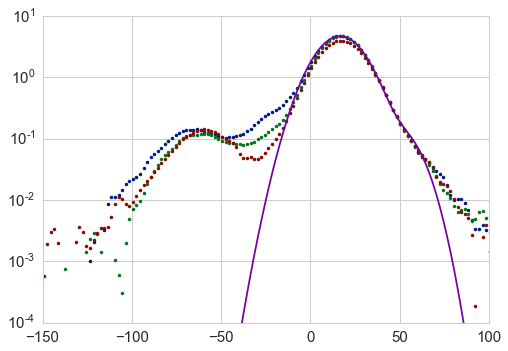

In [29]:
knotspec = hdu.data[181:191, :].sum(axis=0)
belowspec = hdu.data[171:181, :].sum(axis=0)
abovespec = hdu.data[191:201, :].sum(axis=0)
coremodel = Gaussian1D(10.0, 20.0, 10.0) + Gaussian1D(4.0, 40.0, 10.0)
bgmask = np.abs(vels) > 100.0
spec_errors = np.std(knotspec[bgmask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)
coremodel = sfit(coremodel, vels, knotspec, err=spec_errors)	
fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, belowspec, '.')
ax.plot(vels, abovespec, '.')
ax.plot(vels, coremodel(vels))
ax.set(yscale='log', ylim=[1e-4, None], xlim=[-150, 100])

Had to increase the data errors in the core region, since the fit is so bad. 

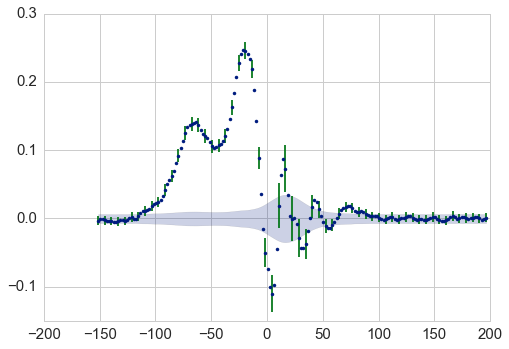

In [30]:
residspec = knotspec - coremodel(vels)
resid_errors = spec_errors + 0.03*np.sqrt((0.02 + knotspec)/knotspec.max())
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=3)
ax.fill_between(vels, -resid_errors, resid_errors, alpha=0.2)

Looks like we are going to need 3 Gaussians to fit the knot region. 

In [31]:
knotmodel = (Gaussian1D(0.03, -100.0, 10.0) 
             + Gaussian1D(0.2, -65.0, 10.0) 
             + Gaussian1D(0.3, -15.0, 10.0))
knotmodel = sfit(knotmodel, vels, residspec, err=resid_errors)
print(sfit.fit_info)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude_0', 'wrap_.mean_0', 'wrap_.stddev_0', 'wrap_.amplitude_1', 'wrap_.mean_1', 'wrap_.stddev_1', 'wrap_.amplitude_2', 'wrap_.mean_2', 'wrap_.stddev_2')
parvals        = (0.0051432024646162538, -108.18282015686425, 4.3636343106850601, 0.13847054348736201, -61.936989399459208, 19.339559142284777, 0.24384875165838962, -20.579191229789654, 9.3427012183548914)
statval        = 219.80952869696972
istatval       = 1736.359576853944
dstatval       = 1516.55004816
numpoints      = 175
dof            = 166
qval           = 0.00327213003256
rstat          = 1.3241537873311429
message        = successful termination
nfev           = 175


<Container object of 3 artists>

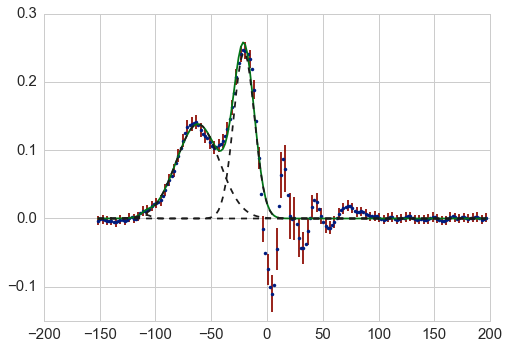

In [32]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, residspec, '.')
ax.plot(vels, knotmodel(vels))
for k in knotmodel.submodel_names:
    ax.plot(vels, knotmodel[k](vels), ls='--', c='k')
ax.errorbar(vels, residspec, resid_errors, fmt=None, errorevery=2)


In [33]:
fastspec = residspec - (knotmodel['None_1'] + knotmodel['None_2'])(vels) 

[(-0.03, 0.05), (-150, 0)]

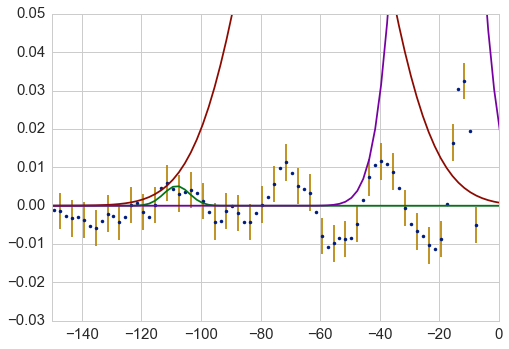

In [34]:
fig, ax = plt.subplots(1, 1)
ax.plot(vels, fastspec, '.')
ax.plot(vels, knotmodel['None_0'](vels))
ax.plot(vels, knotmodel['None_1'](vels))
ax.plot(vels, knotmodel['None_2'](vels))
ax.errorbar(vels, fastspec, spec_errors, fmt=None, errorevery=2)
ax.set(xlim=[-150, 0], ylim=[-0.03, 0.05])

So it is really tricky if we just use the knot section itself. But what if we subtract off a section just below - that should remove a lot of the -65 km/s component.

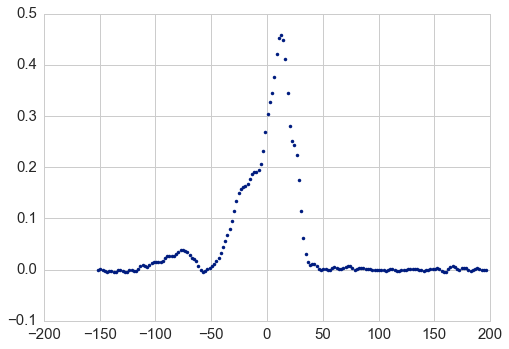

In [35]:
fastspec = knotspec - 0.5*(abovespec + belowspec)
fig, ax = plt.subplots(1, 1)
ax.plot(vels, fastspec, '.')

Try 4 Gaussians for the core model

Estimated data errors: 0.00189615


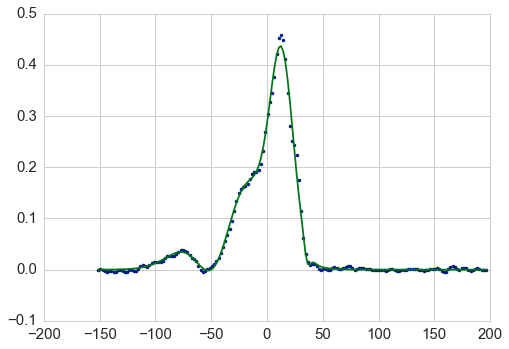

In [36]:
coremodel = (Gaussian1D(0.1, -25.0, 10.0) 
             + Gaussian1D(0.1, 0.0, 10.0)
             + Gaussian1D(0.5, 15.0, 10.0)
             + Gaussian1D(0.3, 40.0, 10.0))
             
bgmask = np.abs(vels) > 150.0
spec_errors = np.std(knotspec[bgmask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)
coremodel = sfit(coremodel, vels, fastspec, err=spec_errors)	
fig, ax = plt.subplots(1, 1)
ax.plot(vels, fastspec, '.')
ax.plot(vels, coremodel(vels))

No, this is just as hopeless really.

Final attempt – fit models to velocity range [-90, 0] and then look at the residual. 

In [70]:
hdu, = fits.open(datadir + '/XX1620-2010-01-236-ha-vhel.fits')
NS, NV = hdu.data.shape
w = WCS(hdu.header)
vels, _ = w.all_pix2world(np.arange(NV), [0]*NV, 0)
vels /= 1000.0 
vels.min(), vels.max()

(-151.39536174627995, 196.36548329774004)

Estimated data errors: 0.00246095


[(-0.071615242958068856, 0.78776767253875735), (-150.0, 0.0)]

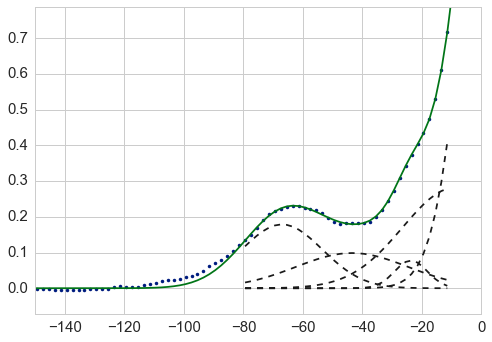

In [73]:
knotspec = hdu.data[178:194, :].sum(axis=0)
bgmask = np.abs(vels) > 150.0
slowmask = (vels > -80.0) & (vels < -10.0)

bounds = {'amplitude': [0, None], 'stddev': [0.0, 20.0]}
slowmodel = (Gaussian1D(1.0, -70.0, 10.0, bounds=bounds) 
             + Gaussian1D(1.0, -50.0, 10.0, bounds=bounds)
             + Gaussian1D(1.0, -30.0, 10.0, bounds=bounds)
             + Gaussian1D(1.0, -10.0, 10.0, bounds=bounds)
             + Gaussian1D(1.0, 10.0, 10.0, bounds=bounds))

spec_errors = np.std(knotspec[bgmask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)
slowmodel = sfit2(slowmodel, vels[slowmask], knotspec[slowmask], 
                 err=spec_errors[slowmask])	


fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, slowmodel(vels))
for k in slowmodel.submodel_names:
    ax.plot(vels[slowmask], slowmodel[k](vels[slowmask]), ls='--', c='k')
specmax = knotspec[slowmask].max()
ax.set(xlim=[-150.0, 0.0], ylim=[-0.1*specmax, 1.1*specmax])

In [74]:
print(sfit2.fit_info)

datasets       = None
itermethodname = none
methodname     = neldermead
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude_0', 'wrap_.mean_0', 'wrap_.stddev_0', 'wrap_.amplitude_1', 'wrap_.mean_1', 'wrap_.stddev_1', 'wrap_.amplitude_2', 'wrap_.mean_2', 'wrap_.stddev_2', 'wrap_.amplitude_3', 'wrap_.mean_3', 'wrap_.stddev_3', 'wrap_.amplitude_4', 'wrap_.mean_4', 'wrap_.stddev_4')
parvals        = (0.17861025518500165, -67.011890802840782, 13.568275901286306, 0.098511513159836236, -43.50465649202264, 18.851273163541268, 0.28179692536803364, -8.8322135468012046, 17.614736022709238, 0.077713631540542893, -23.683816760572661, 5.5095306005490192, 2.2006673245414961, 10.656704720970225, 12.062235837348506)
statval        = 35.35448863210864
istatval       = 5052845.834645515
dstatval       = 5052810.48016
numpoints      = 35
dof            = 20
qval           = 0.0182955482699
rstat          = 1.7677244316054321
message        = Optimization terminated successfully


Rstat is bigger than 3, so it is not a good fit.  But this doesn't matter. 

Estimated data errors: 0.00298880401116


[(-0.008, 0.03), (-150, 0)]

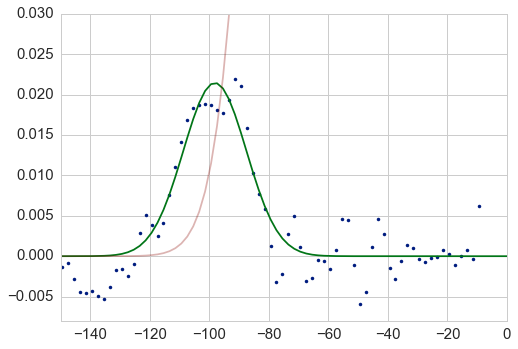

In [76]:
mask = vels < -50.0
fastspec = knotspec - slowmodel(vels)
bgmask = (vels < -130) | (vels > -80)
spec_errors = np.std(fastspec[bgmask & mask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)

fastmodel = Gaussian1D(0.01, -100.0, 10.0) 
fastmodel = sfit(fastmodel, vels[mask], fastspec[mask], err=spec_errors[mask])
fig, ax = plt.subplots(1, 1)
ax.plot(vels, fastspec, '.')
ax.plot(vels, fastmodel(vels))
ax.plot(vels, slowmodel(vels), alpha=0.3)

ax.set(xlim=[-150, 0], ylim=[-8e-3, 3e-2])


In [77]:
print(sfit.fit_info)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude', 'wrap_.mean', 'wrap_.stddev')
parvals        = (0.021462352202207768, -98.154842427032108, 10.628235012202916)
statval        = 51.40373084851779
istatval       = 201.56555098451577
dstatval       = 150.161820136
numpoints      = 51
dof            = 48
qval           = 0.341922889296
rstat          = 1.0709110593441207
message        = successful termination
nfev           = 37


Rstat is less than 3, so we can find the errors on the parameters.

In [78]:
param_errors = sfit.est_errors(sigma=3)
param_errors

wrap_.amplitude lower bound:	-0.00336496
wrap_.amplitude upper bound:	0.0035188
wrap_.mean lower bound:	-2.07944
wrap_.mean upper bound:	2.04925
wrap_.stddev lower bound:	-1.66566
wrap_.stddev upper bound:	1.97465


(['amplitude', 'mean', 'stddev'],
 (0.021462352202207768, -98.154842427032108, 10.628235012202916),
 (-0.0033649570442955135, -2.0794432506589402, -1.6656629553092746),
 (0.0035187998030888554, 2.0492527947779564, 1.9746492386125301))

[(-0.008, 0.03), (-150, 0)]

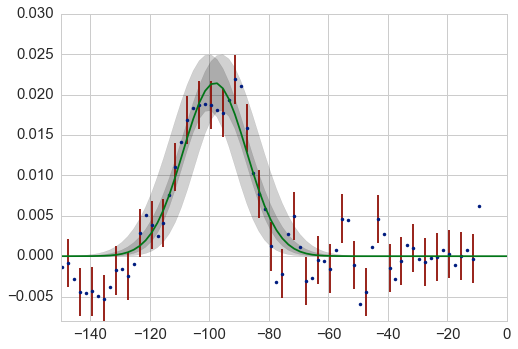

In [80]:
knot_minmin = fastmodel.copy()
knot_maxmax = fastmodel.copy()
knot_minmax = fastmodel.copy()
knot_maxmin = fastmodel.copy()

knot_minmin.amplitude.value += param_errors[2][0]
knot_minmin.mean.value += param_errors[2][1]
knot_minmin.stddev.value += param_errors[2][2]

knot_maxmax.amplitude.value += param_errors[3][0]
knot_maxmax.mean.value += param_errors[3][1]
knot_maxmax.stddev.value += param_errors[3][2]

knot_minmax.amplitude.value += param_errors[2][0]
knot_minmax.mean.value += param_errors[3][1]
knot_minmax.stddev.value += param_errors[2][2]

knot_maxmin.amplitude.value += param_errors[3][0]
knot_maxmin.mean.value += param_errors[2][1]
knot_maxmin.stddev.value += param_errors[3][2]

fig, ax = plt.subplots(1, 1)
ax.plot(vels, fastspec, '.')
ax.plot(vels, fastmodel(vels))
ax.errorbar(vels, fastspec, spec_errors, fmt=None, errorevery=2)
ax.fill_between(vels, knot_minmax(vels), knot_maxmin(vels), color='k', alpha=0.2)
ax.fill_between(vels, knot_minmin(vels), knot_maxmax(vels), color='k', alpha=0.2)
ax.set(xlim=[-150, 0], ylim=[-8e-3, 3e-2])


Now try the same with the [N II] line.

In [82]:
hdu, = fits.open(datadir + '/XX1620-2010-01-236-nii-vhel.fits')
NS, NV = hdu.data.shape
w = WCS(hdu.header)
vels, _ = w.all_pix2world(np.arange(NV), [0]*NV, 0)
vels /= 1000.0 
vels.min(), vels.max()

(-151.07218013332005, 196.68708043189991)

Estimated data errors: 0.00128872


[(-0.033898019790649415, 0.37287821769714358), (-150.0, 0.0)]

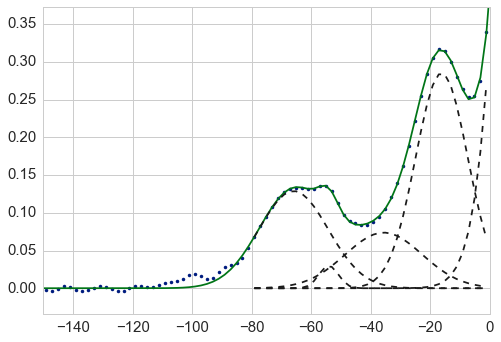

In [83]:
knotspec = hdu.data[178:194, :].sum(axis=0)
bgmask = np.abs(vels) > 150.0
slowmask = (vels > -80.0) & (vels < 0.0)


bounds = {'amplitude': [0, None], 'stddev': [0.0, 20.0]}
slowmodel = (Gaussian1D(1.0, -70.0, 10.0, bounds=bounds) 
             + Gaussian1D(1.0, -50.0, 10.0, bounds=bounds)
             + Gaussian1D(1.0, -30.0, 10.0, bounds=bounds)
             + Gaussian1D(1.0, -10.0, 10.0, bounds=bounds)
             + Gaussian1D(1.0, 10.0, 10.0, bounds=bounds))

spec_errors = np.std(knotspec[bgmask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)
slowmodel = sfit2(slowmodel, vels[slowmask], knotspec[slowmask], 
                 err=spec_errors[slowmask])	


fig, ax = plt.subplots(1, 1)
ax.plot(vels, knotspec, '.')
ax.plot(vels, slowmodel(vels))
for k in slowmodel.submodel_names:
    ax.plot(vels[slowmask], slowmodel[k](vels[slowmask]), ls='--', c='k')
specmax = knotspec[slowmask].max()
ax.set(xlim=[-150.0, 0.0], ylim=[-0.1*specmax, 1.1*specmax])

In [84]:
print(sfit2.fit_info)

datasets       = None
itermethodname = none
methodname     = neldermead
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude_0', 'wrap_.mean_0', 'wrap_.stddev_0', 'wrap_.amplitude_1', 'wrap_.mean_1', 'wrap_.stddev_1', 'wrap_.amplitude_2', 'wrap_.mean_2', 'wrap_.stddev_2', 'wrap_.amplitude_3', 'wrap_.mean_3', 'wrap_.stddev_3', 'wrap_.amplitude_4', 'wrap_.mean_4', 'wrap_.stddev_4')
parvals        = (0.12885187352552679, -65.962035072506382, 11.65196098790123, 0.029865447284407862, -54.168290272063125, 3.2640079535002173, 0.073745783695155012, -35.653940719017761, 12.920362558748625, 0.28529837178684625, -16.176868072910846, 8.777616421955809, 4.962472764109032, 29.020594988220999, 12.508503322805419)
statval        = 43.40571195790779
istatval       = 26051023.942228183
dstatval       = 26050980.5365
numpoints      = 40
dof            = 25
qval           = 0.0126281513782
rstat          = 1.7362284783163116
message        = Optimization terminated successfully
n

Estimated data errors: 0.0015140981965


[(-0.005, 0.05), (-150, 0)]

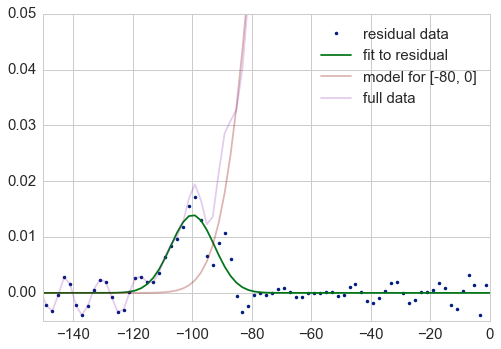

In [89]:
mask = vels < -50.0
fastspec = knotspec - slowmodel(vels)
bgmask = (vels < -130) | (vels > -80)
spec_errors = np.std(fastspec[bgmask & mask])
print('Estimated data errors:', spec_errors)
spec_errors *= np.ones_like(vels)

fastmodel = Gaussian1D(0.01, -100.0, 10.0) 
fastmodel = sfit(fastmodel, vels[mask], fastspec[mask], err=spec_errors[mask])
fig, ax = plt.subplots(1, 1)
ax.plot(vels, fastspec, '.', label='residual data')
ax.plot(vels, fastmodel(vels), label='fit to residual')
ax.plot(vels, slowmodel(vels), alpha=0.3, label='model for [-80, 0]')
ax.plot(vels, knotspec, alpha=0.2, label='full data')
ax.legend()
ax.set(xlim=[-150, 0], ylim=[-5e-3, 5e-2])


In [86]:
print(sfit.fit_info)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('wrap_.amplitude', 'wrap_.mean', 'wrap_.stddev')
parvals        = (0.01396974461651266, -99.871041686939165, 7.296334075830309)
statval        = 102.01560741487835
istatval       = 141.25035668510435
dstatval       = 39.2347492702
numpoints      = 51
dof            = 48
qval           = 9.11705191293e-06
rstat          = 2.125325154476632
message        = successful termination
nfev           = 21


In [60]:
param_errors = sfit.est_errors(sigma=3)
param_errors

wrap_.amplitude lower bound:	-0.00211101
wrap_.amplitude upper bound:	0.002241
wrap_.mean lower bound:	-1.32979
wrap_.mean upper bound:	1.32813
wrap_.stddev lower bound:	-1.22528
wrap_.stddev upper bound:	1.38883


(['amplitude', 'mean', 'stddev'],
 (0.01396974461651266, -99.871041686939165, 7.296334075830309),
 (-0.0021110138028312946, -1.3297866177315996, -1.2252829461682078),
 (0.0022410005290120737, 1.3281308975152228, 1.3888336145798128))

[(-0.008, 0.02), (-150, 0)]

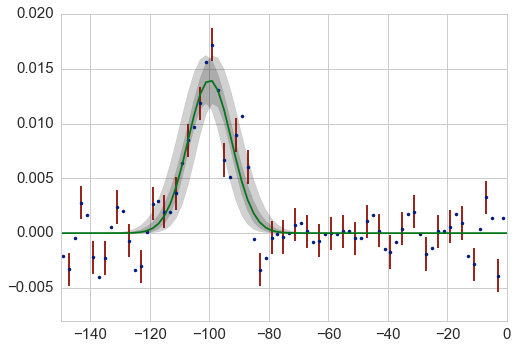

In [61]:
knot_minmin = fastmodel.copy()
knot_maxmax = fastmodel.copy()
knot_minmax = fastmodel.copy()
knot_maxmin = fastmodel.copy()

knot_minmin.amplitude.value += param_errors[2][0]
knot_minmin.mean.value += param_errors[2][1]
knot_minmin.stddev.value += param_errors[2][2]

knot_maxmax.amplitude.value += param_errors[3][0]
knot_maxmax.mean.value += param_errors[3][1]
knot_maxmax.stddev.value += param_errors[3][2]

knot_minmax.amplitude.value += param_errors[2][0]
knot_minmax.mean.value += param_errors[3][1]
knot_minmax.stddev.value += param_errors[2][2]

knot_maxmin.amplitude.value += param_errors[3][0]
knot_maxmin.mean.value += param_errors[2][1]
knot_maxmin.stddev.value += param_errors[3][2]

fig, ax = plt.subplots(1, 1)
ax.plot(vels, fastspec, '.')
ax.plot(vels, fastmodel(vels))
ax.errorbar(vels, fastspec, spec_errors, fmt=None, errorevery=2)
ax.fill_between(vels, knot_minmax(vels), knot_maxmin(vels), color='k', alpha=0.2)
ax.fill_between(vels, knot_minmin(vels), knot_maxmax(vels), color='k', alpha=0.2)
ax.set(xlim=[-150, 0], ylim=[-8e-3, 2e-2])
